BoutInf (nBoutsx18):
- Columns 1 and 2: the start and end of the bout data in the continuous data variables
- Column 3: Number indicating the stimulus being shown during that bout
- Column 4: Original frame start number (allows actual timing of bout to be known, given 700 Hz frame rate)
- Columns 5:7 Pre-bout x, y position and theta in pixels and radians (???)
- Column 8: Eye Convergence during bout (2: converged; 1: not converged)
- Column 9: Change in eye convergence angle (degrees) during bout
- Column 10: Assigned eye convergence category (1=converge during  bout; 2=not converged ;  3=converged; 4=diverge during bout)
- Column 11: Bout category assigned using the scheme in Marques et al. 2018 (1=SCS; 2=LCS; 3=BS; 4=O-bend; 5=J-turn; 6=SLC; 7=S1; 8=RT; 9=S2; 10=LLC; 11=AS; 12=SAT; 13=HAT)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, ensure_dir, ZEBRAFISH_DIR
import urllib.request
ZEBRAFISH_DIR

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/data/raw/ZEBRAFISH_Data_Dir')

In [8]:
from tqdm.autonotebook import tqdm
import h5py
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
mat_files = list(ZEBRAFISH_DIR.glob('**/*.mat'))

In [5]:
len(mat_files)

650

In [6]:
mat_files[0]

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/data/raw/ZEBRAFISH_Data_Dir/Phototaxis/Phototaxis4/Phototaxis400004.mat')

In [7]:
bout_df = pd.DataFrame(columns = ['mat_loc', 'bouts', 'bout_lens'])
for mfi, mat_file in enumerate(tqdm(mat_files)):
    ds = scipy.io.loadmat(mat_file.as_posix())
    BoutInf = ds['boutStructure'][0][0][0]
    bout_category = BoutInf[:,-1].astype('int')
    bout_df.loc[len(bout_df)] = [mat_file.as_posix(), bout_category, len(bout_category)]

In [9]:
bout_df[:3]

,mat_loc,bouts,bout_lens
0,/mnt/cube/tsainbur/Projects/github_repos/child...,"[12, 8, 9, 8, 7, 7, 8, 8, 13, 7, 8, 8, 8, 8, 8...",1808
1,/mnt/cube/tsainbur/Projects/github_repos/child...,"[13, 7, 12, 7, 9, 9, 9, 8, 13, 7, 7, 7, 8, 7, ...",1528
2,/mnt/cube/tsainbur/Projects/github_repos/child...,"[7, 8, 12, 8, 9, 7, 9, 9, 7, 9, 7, 7, 5, 8, 7,...",2296


In [10]:
len(bout_df)

650

In [11]:
np.unique(np.concatenate(bout_df.bouts.values))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [12]:
np.sum(bout_df.bout_lens)

1869270

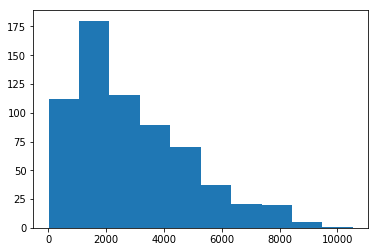

In [13]:
plt.hist(bout_df.bout_lens.values.astype('int'));

### Mutual information

In [14]:
bouts = [list(i.astype('int'))  for i in bout_df.bouts.values]

In [15]:
def remove_repeats(sequence):
    return [element for i, element in enumerate(sequence[1:]) if sequence[i] != element]

In [16]:
bouts_indv = [["{}_{}".format(bi, element) for element in bout] for bi, bout in enumerate(tqdm(bouts))]

In [17]:
bouts_indv_rr = [remove_repeats(i) for i in bouts_indv]

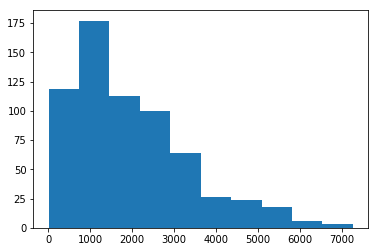

In [18]:
plt.hist([len(i) for i in bouts_indv_rr]);

In [19]:
from childes_mi.information_theory import mutual_information as mi

In [20]:
distances = np.arange(1,1001)

In [21]:
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    bouts_indv_rr, distances=distances, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:  4.3min


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.0min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:  4.6min


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.0min finished


In [22]:
MI_DF = pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances"],
)

In [23]:
MI_DF

,MI,MI_var,shuff_MI,shuff_MI_var,distances
0,"[12.756969938471917, 12.538684026238826, 12.49...","[0.0029165967585350204, 0.0028949948700791647,...","[12.460189963044343, 12.459536533510143, 12.45...","[0.0029017535831442416, 0.0029036948042808312,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [24]:
MI_DF.to_pickle(DATA_DIR / "mi" / "zebra_fish_1000.pickle")

In [58]:
row = MI_DF.iloc[0]

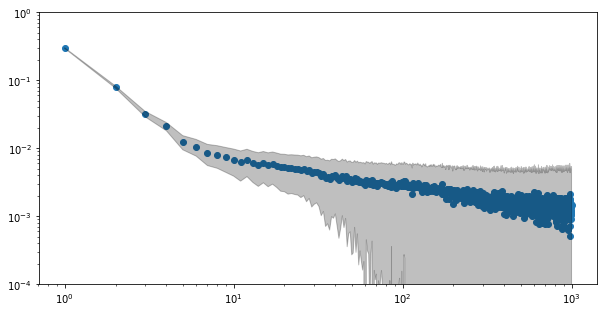

In [62]:
fig, ax = plt.subplots(figsize=(10,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
ax.set_ylim([1e-4, 1])
ax.set_yscale('log')
ax.set_xscale('log')

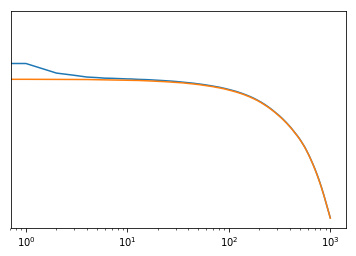

In [29]:
plt.loglog(row.MI)
plt.loglog(row.shuff_MI)

### longest sequence

In [74]:
from pathlib2 import Path

In [75]:
bout_df['condition'] = [Path(i).parent.parent.stem for i in bout_df.mat_loc.values]

In [76]:
bout_df[:3]

,mat_loc,bouts,bout_lens,condition
0,/mnt/cube/tsainbur/Projects/github_repos/child...,"[12, 8, 9, 8, 7, 7, 8, 8, 13, 7, 8, 8, 8, 8, 8...",1808,Phototaxis
1,/mnt/cube/tsainbur/Projects/github_repos/child...,"[13, 7, 12, 7, 9, 9, 9, 8, 13, 7, 7, 7, 8, 7, ...",1528,Phototaxis
2,/mnt/cube/tsainbur/Projects/github_repos/child...,"[7, 8, 12, 8, 9, 7, 9, 9, 7, 9, 7, 7, 5, 8, 7,...",2296,Phototaxis


In [79]:
nex = 50
MI_DFs = []
for idx, row in tqdm(bout_df.sort_values(by=['bout_lens'], ascending=False)[:nex].iterrows(), total=nex):
    seq = row.bouts
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        [remove_repeats(seq)], distances=distances, n_jobs=-1, estimate=True
    )
    
    MI_DF1 = pd.DataFrame(
        [[MI, MI_var, shuff_MI, shuff_MI_var, distances, row.condition, row.bout_lens]],
        columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances", "condition", "bout_len"],
    )
    MI_DFs.append(MI_DF1)
MI_DF_longest = pd.concat(MI_DFs)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:    3.4s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


In [81]:
MI_DF_longest[:5]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,condition,bout_len
0,"[4.264652049488794, 4.032833268720761, 3.97823...","[0.042048957289041226, 0.04176368410968221, 0....","[3.9378467911968427, 3.9382264995030596, 3.937...","[0.0417505257546853, 0.04219246908182834, 0.04...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",PreyCaptureExpTu,10539
0,"[4.169567544973178, 3.946277311538317, 3.91747...","[0.04421004200719924, 0.043688129727450536, 0....","[3.911807872685933, 3.91086716127527, 3.913607...","[0.0437013530132464, 0.04397259785760278, 0.04...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",PreyCaptureExpTu,9260
0,"[4.183013511698773, 3.926281907984448, 3.89161...","[0.04786305983868839, 0.04754229067736407, 0.0...","[3.875292068455529, 3.875013166612625, 3.87476...","[0.04772779873524221, 0.047340915144550334, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",PreyCaptureNaiveTu,9254
0,"[4.14932865868686, 3.929049893514782, 3.908833...","[0.03882365217056434, 0.03888323028688894, 0.0...","[3.8971429927061063, 3.8983847619307834, 3.901...","[0.038279018804743666, 0.03855934579527864, 0....","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",PreyCaptureSmallRotTuWithRot,8820
0,"[4.129459069019715, 3.889554190589057, 3.84991...","[0.03525374547129882, 0.03508958100275208, 0.0...","[3.8326969719003063, 3.830964080732697, 3.8310...","[0.035459083619052, 0.035424952388913744, 0.03...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",PreyCaptureExpTu,8465


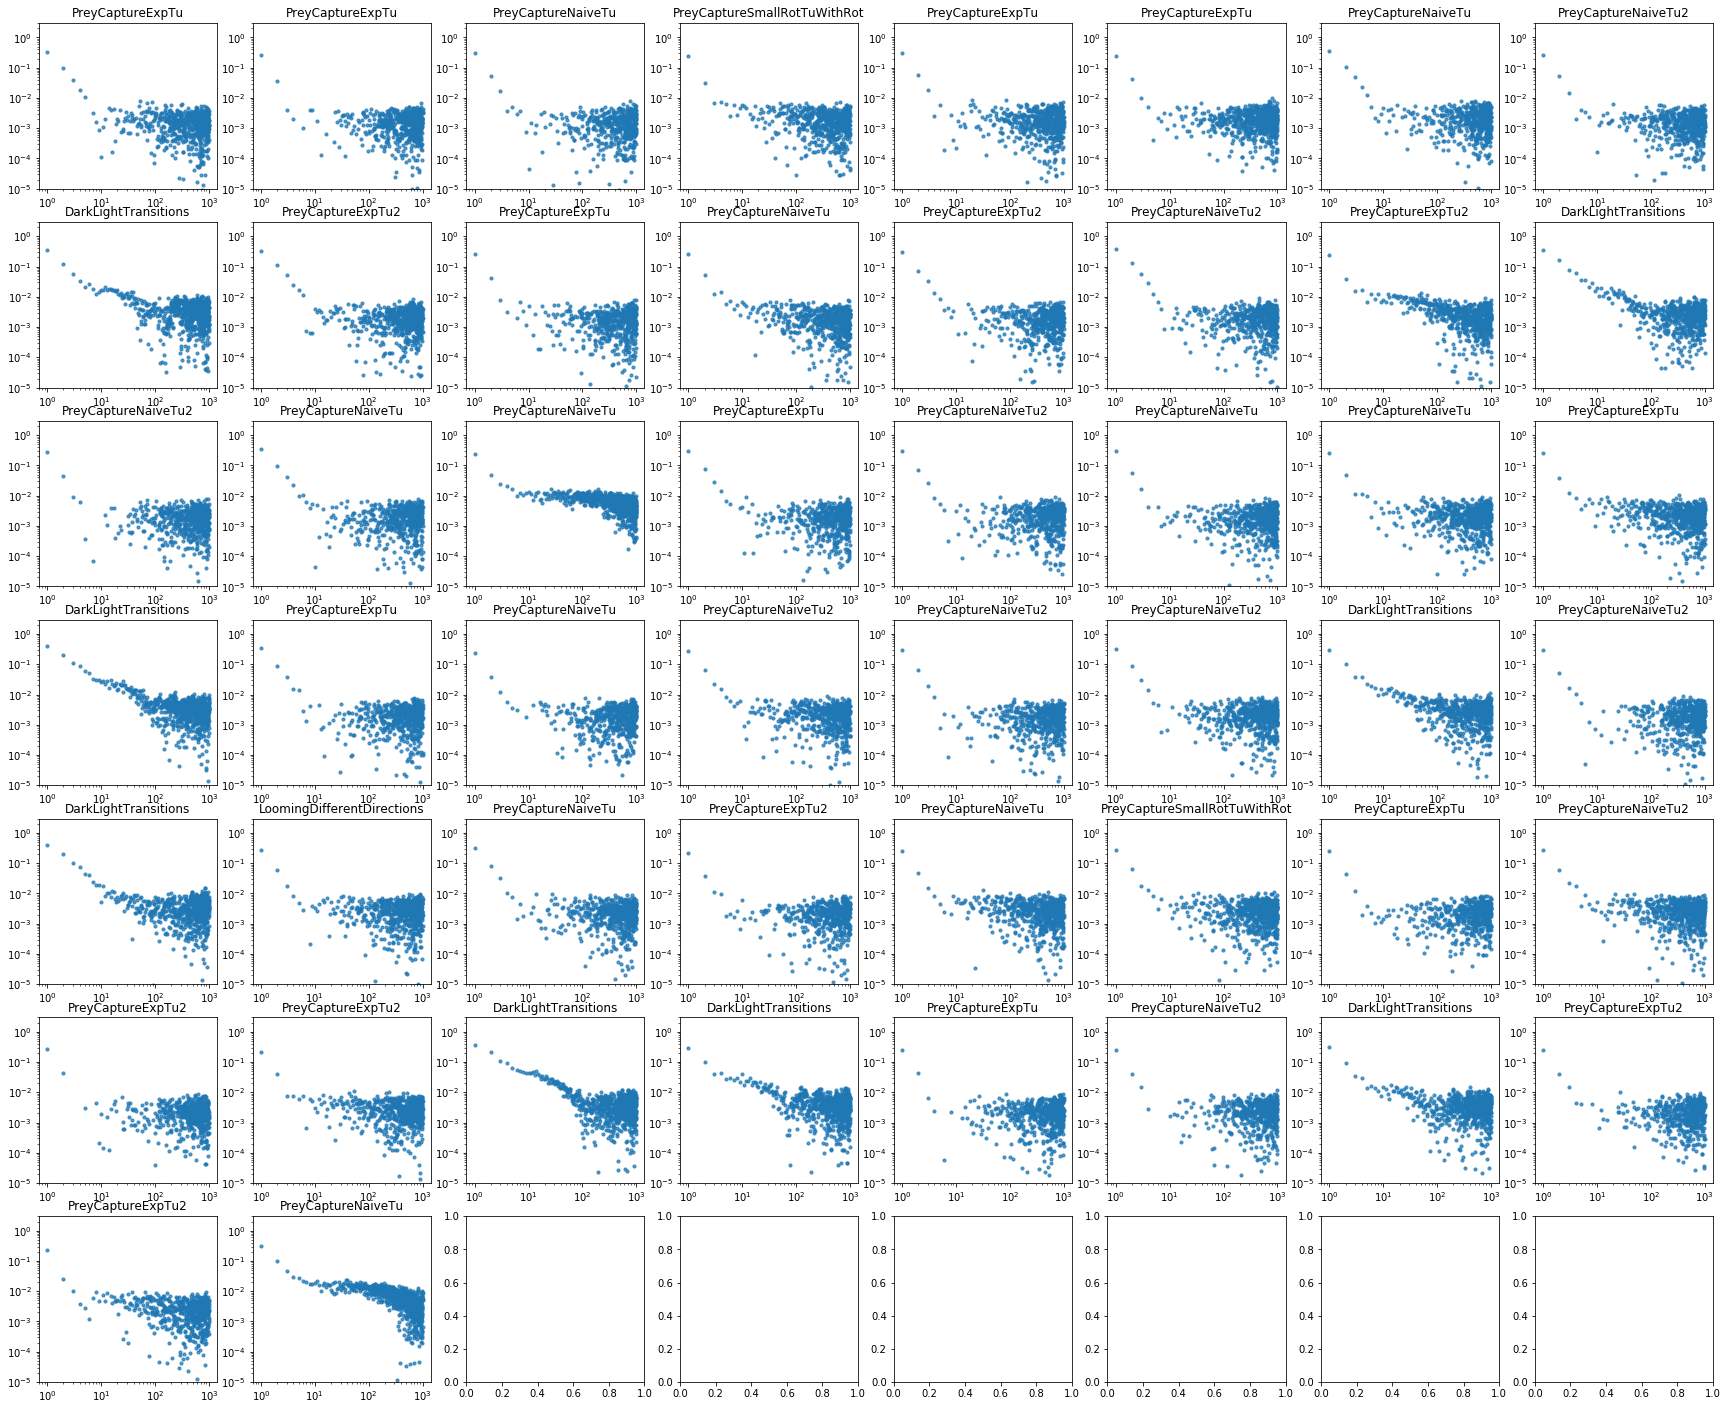

In [86]:
fig, axs = plt.subplots(ncols = 8, nrows=7, figsize = (30,25))
for ri, (idx, row) in tqdm(enumerate(MI_DF_longest.iterrows())):
    ax = axs.flatten()[ri]
    MI = row.MI-row.shuff_MI
    MI_var = row.MI_var
    ax.set_title(row.condition)
    ax.scatter(distances, MI, alpha=0.75, s=10)
    #ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
    ax.set_ylim([1e-5, 3])
    ax.set_yscale('log')
    ax.set_xscale('log')